In [1]:
import numpy as np
from lab2_proto import *
from lab2_tools import *
from prondict import prondict
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# Data contains MFCC features
data = np.load('lab2_data.npz', allow_pickle=True)['data']

# Models to test functions, trained on TIDIGITS with 13 MFCC feature vectors
models_onespkr = np.load('lab2_models_onespkr.npz', allow_pickle=True) # trained on a single speaker (female)
models_all = np.load('lab2_models_all.npz', allow_pickle=True) # trained on full training set

# Example for debugging
example = np.load('lab2_example.npz', allow_pickle=True)["example"].item()

# Load one of the model files
phoneHMMs_onespkr = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
# phoneHMMs is a dictionary with 21 keys each corresponding to a phonetic model

In [3]:
list(sorted(phoneHMMs_onespkr.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [4]:
list(sorted(phoneHMMs_all.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [5]:
phoneHMMs_onespkr['ah'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

In [6]:
# Pronounciation dictionary: Mapping between digits (words) and phonetic models can be obtained with the pronunciation
prondict

{'o': ['ow'],
 'z': ['z', 'iy', 'r', 'ow'],
 '1': ['w', 'ah', 'n'],
 '2': ['t', 'uw'],
 '3': ['th', 'r', 'iy'],
 '4': ['f', 'ao', 'r'],
 '5': ['f', 'ay', 'v'],
 '6': ['s', 'ih', 'k', 's'],
 '7': ['s', 'eh', 'v', 'ah', 'n'],
 '8': ['ey', 't'],
 '9': ['n', 'ay', 'n']}

# Add silence in begining and end of each utterance (word)

In [7]:
# Because we are working with recordings of isolated digits, a model of each utterance should
# also contain initial and final silence:

isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    
isolated

{'o': ['sil', 'ow', 'sil'],
 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil'],
 '1': ['sil', 'w', 'ah', 'n', 'sil'],
 '2': ['sil', 't', 'uw', 'sil'],
 '3': ['sil', 'th', 'r', 'iy', 'sil'],
 '4': ['sil', 'f', 'ao', 'r', 'sil'],
 '5': ['sil', 'f', 'ay', 'v', 'sil'],
 '6': ['sil', 's', 'ih', 'k', 's', 'sil'],
 '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'],
 '8': ['sil', 'ey', 't', 'sil'],
 '9': ['sil', 'n', 'ay', 'n', 'sil']}

# 4. Concatenating HMMs

In [8]:
wordHMMs = {}
wordHMMs['o'] = concatHMMs(phoneHMMs_onespkr, isolated['o'])

## Build HMM models for each utterance in prondict

In [9]:
wordHMMs = {}
for uterance in isolated:
    wordHMMs[uterance] = concatHMMs(phoneHMMs_onespkr, isolated[uterance]) # one speaker
    #wordHMMs[uterance] = concatHMMs(phoneHMMs_all, isolated[uterance]) # all speakers

# 4.1 Example

In [10]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()

In [11]:
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

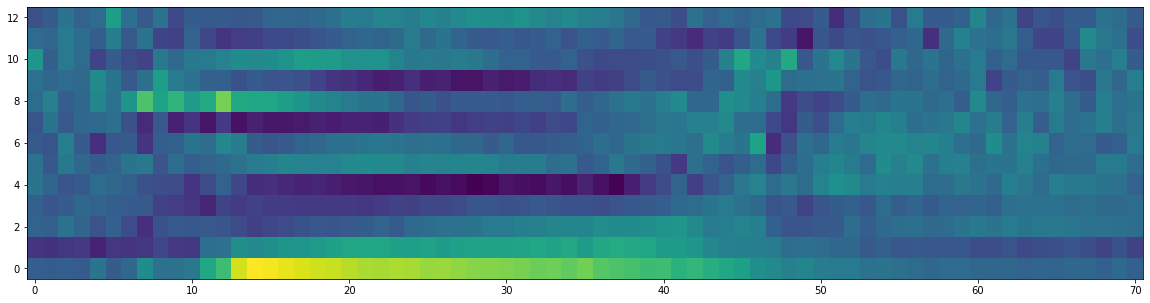

In [12]:
plt.figure(figsize=(20,5))
plt.imshow(example['lmfcc'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.show()

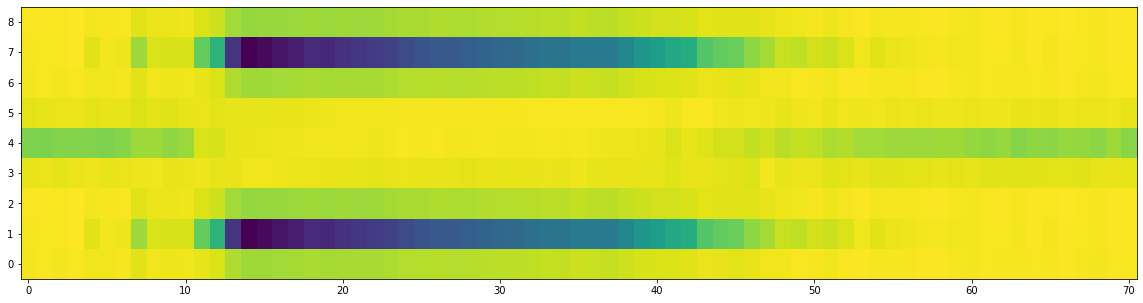

In [13]:
plt.figure(figsize=(20,5))
plt.imshow(example['obsloglik'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.show()

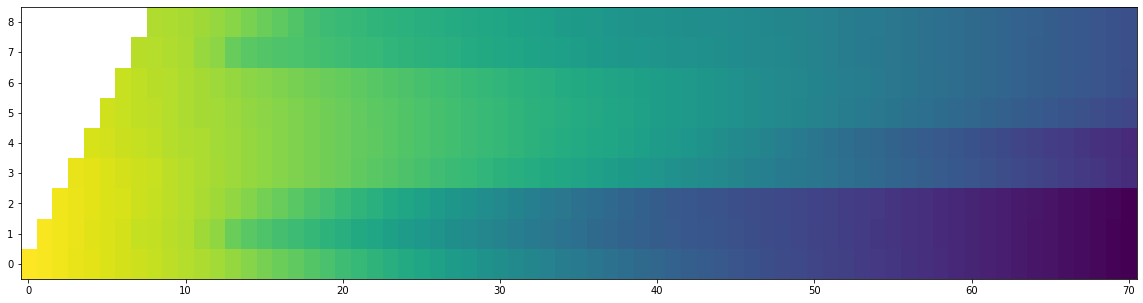

In [14]:
plt.figure(figsize=(20,5))
plt.imshow(example['logalpha'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.show()

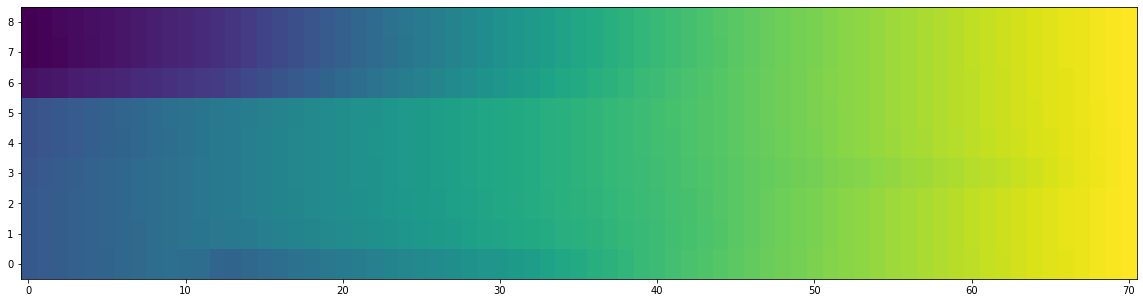

In [15]:
plt.figure(figsize=(20,5))
plt.imshow(example['logbeta'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.show()

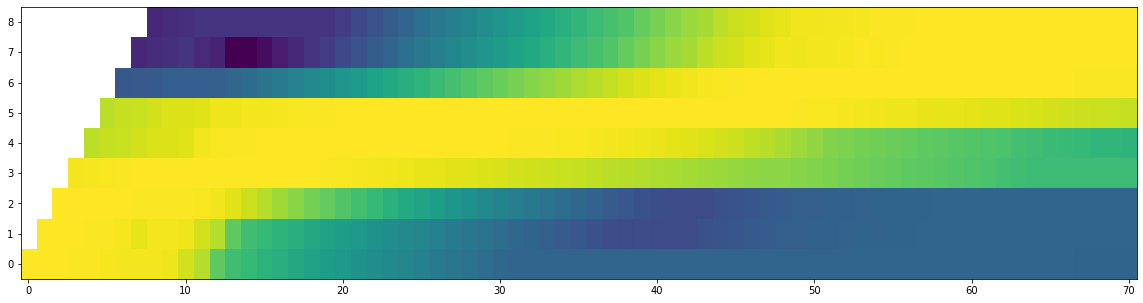

In [16]:
plt.figure(figsize=(20,5))
plt.imshow(example['loggamma'].T, aspect='auto', interpolation='nearest', origin='lower')
plt.show()

# 5. HMM Likelihood and Recognition 

## 5.1 Gaussian emission probabilities

Observation log likelihood of an utterance is the likelihood of each frame of the utterance for every Gaussian model of each of the possible states of the HMM model.

In [17]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])
compare(obsloglik, example['obsloglik'])

True

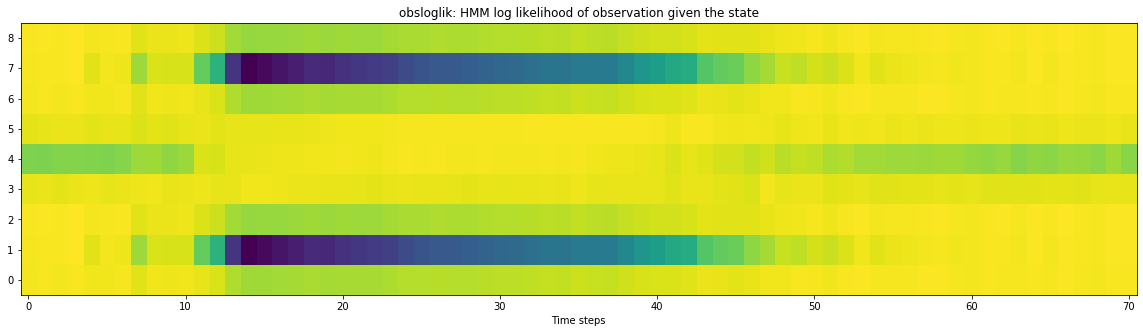

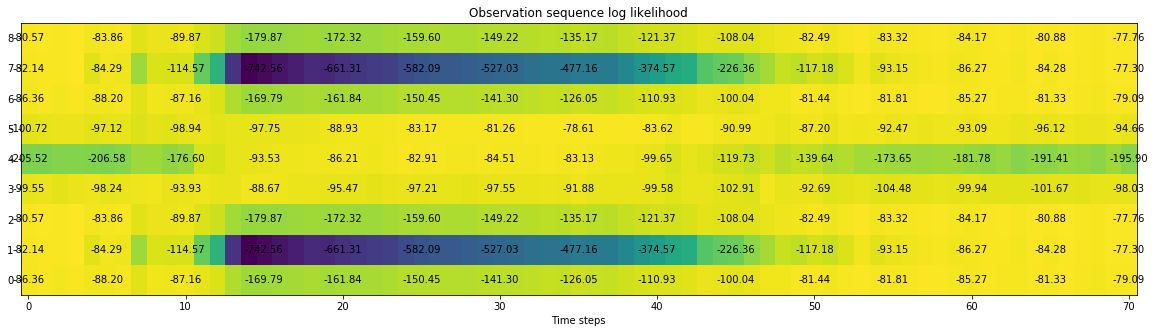

In [18]:
plt.figure(figsize=(20,5))
plt.imshow(example['obsloglik'].T, interpolation='nearest', aspect='auto', origin='lower')
plt.xlabel("Time steps")
plt.title("obsloglik: HMM log likelihood of observation given the state")
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(obsloglik.T, interpolation='nearest', aspect='auto', origin='lower')
# plt.imshow(obsloglik, interpolation='nearest', aspect='auto', origin='lower')

# Plot loglikelihood over time steps for Gaussians
for (i, j), z in np.ndenumerate(obsloglik):
    # print((i,j), z)
    if np.mod(i, 5) == 0 and np.mod(j, 1) == 0:
        plt.text(i, j, '{:.2f}'.format(z), ha='center', va='center')
plt.xlabel("Time steps")
        
plt.title("Observation sequence log likelihood")
plt.show()

Observing the plot, time steps from ~10 to ~50 correspond to the utterance itself ('ow'), wheras time steps 0 to ~10 and time steps ~50 to 70 represent the silence 'sil' which was added to the utterances. From the plot it can be interpreted that the the observations during the time steps corresponding to the utterance 'ow' have small log likelihoods for the 1st and 7th Gaussian, and 'sil' is more equally distributed over the Gaussians, with somewhat lower log likelihood for the 4th Gaussian. 

(the darker the plot, the lower the log likelihood)

## 5.2 Forward Algorithm

In [19]:
import warnings
warnings.filterwarnings('ignore')

log_startprob = np.log(wordHMMs['o']['startprob'])
log_transmat = np.log(wordHMMs['o']['transmat'])

logalpha = forward(obsloglik, log_startprob, log_transmat)

compare(logalpha, example['logalpha'])

True

In [20]:
compare(logsumexp(logalpha[-1,:]), example['loglik'])

True

#### Score all the 44 utterances in the data array with each of the 11 HMM models in wordHMMs

In [21]:
max_likelihoods = []
max_likelihood = - np.inf
max_likelihood_HMM = None

for sample in tqdm(data):
    max_likelihood = - np.inf
    dic = {}

    for HMM in wordHMMs:
        
        obs_likelihood = log_multivariate_normal_density_diag(sample['lmfcc'], wordHMMs[HMM]['means'], wordHMMs[HMM]['covars'])
        
        log_startprob = np.log(wordHMMs[HMM]['startprob'])
        log_transmat = np.log(wordHMMs[HMM]['transmat'])
        
        logalpha = forward(obs_likelihood, log_startprob, log_transmat) 

        if logsumexp(logalpha[-1,:]) > max_likelihood:
            max_likelihood = logsumexp(logalpha[-1,:])
            max_likelihood_HMM = HMM
            
    dic[sample['digit'] + '_' + sample['gender']] = max_likelihood_HMM
    dic['maxLikelihood'] = max_likelihood
    
    max_likelihoods.append(dic) 

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:22<00:00,  2.45it/s]


In [22]:
max_likelihoods

[{'o_man': 'o', 'maxLikelihood': -6755.29295367825},
 {'o_man': 'o', 'maxLikelihood': -6097.0523998906965},
 {'z_man': 'z', 'maxLikelihood': -8118.200380361543},
 {'z_man': 'z', 'maxLikelihood': -7687.5887955841135},
 {'1_man': '3', 'maxLikelihood': -6997.069086161187},
 {'1_man': '9', 'maxLikelihood': -7198.409743244815},
 {'2_man': '3', 'maxLikelihood': -6227.59482796606},
 {'2_man': '2', 'maxLikelihood': -7520.048008578062},
 {'3_man': '3', 'maxLikelihood': -7245.060397819047},
 {'3_man': '3', 'maxLikelihood': -8101.060919329966},
 {'4_man': '4', 'maxLikelihood': -7227.865033718987},
 {'4_man': '4', 'maxLikelihood': -7191.665977473049},
 {'5_man': '3', 'maxLikelihood': -7699.838609516217},
 {'5_man': '3', 'maxLikelihood': -7053.1633404817685},
 {'6_man': '6', 'maxLikelihood': -8062.449795380257},
 {'6_man': '6', 'maxLikelihood': -8412.751985655648},
 {'7_man': '3', 'maxLikelihood': -7739.72902402962},
 {'7_man': '3', 'maxLikelihood': -7918.755244419525},
 {'8_man': '3', 'maxLikeliho

The results show that all utterances pronounced by a woman are recognized correctly, which makes sense as the training was done only on one speaker - female.

Only 12 out of 22 of the utterances pronounced by a man are predicted correctly.

# TODO: compare when trained on all speakers

## 5.3 Viterbi Approximation

In [23]:
log_startprob = np.log(wordHMMs['o']['startprob'])
log_transmat = np.log(wordHMMs['o']['transmat'])

True
True


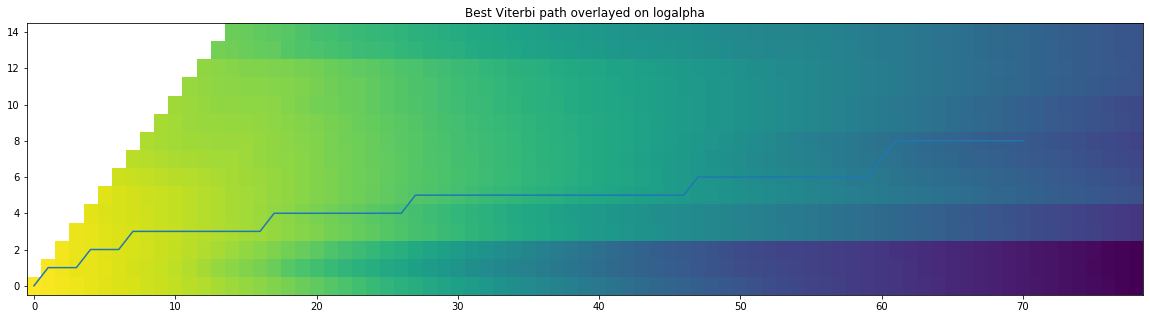

In [24]:
viterbi_loglik, viterbi_path = viterbi(obsloglik, log_startprob, log_transmat)
print(compare(viterbi_loglik, example['vloglik']))
print(compare(viterbi_path, example['vpath']))


plt.figure(figsize=(20,5))
plt.imshow(np.ma.masked_invalid(logalpha).T, aspect='auto', interpolation='nearest', origin='lower')
plt.plot(np.arange(len(viterbi_path)), viterbi_path)
plt.title("Best Viterbi path overlayed on logalpha")
plt.show()

In [25]:
max_likelihoods_viterbi = []
max_likelihood = - np.inf
max_likelihood_HMM = None

for sample in tqdm(data):
    max_likelihood = - np.inf
    dic = {}

    for HMM in wordHMMs:
        
        obs_likelihood = log_multivariate_normal_density_diag(sample['lmfcc'], wordHMMs[HMM]['means'], wordHMMs[HMM]['covars'])
        
        log_startprob = np.log(wordHMMs[HMM]['startprob'])
        log_transmat = np.log(wordHMMs[HMM]['transmat'])
        
        logalpha, _ = viterbi(obs_likelihood, log_startprob, log_transmat) 

        if logalpha > max_likelihood:
            max_likelihood = logalpha
            max_likelihood_HMM = HMM
            
    dic[sample['digit'] + '_' + sample['gender']] = max_likelihood_HMM
    dic['maxLikelihood'] = max_likelihood
    
    max_likelihoods_viterbi.append(dic) 

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  6.44it/s]


In [26]:
max_likelihoods_viterbi

[{'o_man': 'o', 'maxLikelihood': -6757.997215470573},
 {'o_man': 'o', 'maxLikelihood': -6100.253650325265},
 {'z_man': 'z', 'maxLikelihood': -8120.4084077033895},
 {'z_man': 'z', 'maxLikelihood': -7690.9047105911595},
 {'1_man': '3', 'maxLikelihood': -6998.301610596523},
 {'1_man': '9', 'maxLikelihood': -7200.652138504673},
 {'2_man': '3', 'maxLikelihood': -6229.627725505495},
 {'2_man': '2', 'maxLikelihood': -7521.991523893783},
 {'3_man': '3', 'maxLikelihood': -7247.062024450119},
 {'3_man': '3', 'maxLikelihood': -8104.036978231511},
 {'4_man': '4', 'maxLikelihood': -7231.055218794898},
 {'4_man': '4', 'maxLikelihood': -7193.8492178670895},
 {'5_man': '3', 'maxLikelihood': -7700.915074464565},
 {'5_man': '3', 'maxLikelihood': -7054.538626004525},
 {'6_man': '6', 'maxLikelihood': -8065.726815463304},
 {'6_man': '6', 'maxLikelihood': -8415.276197995192},
 {'7_man': '3', 'maxLikelihood': -7741.489436564968},
 {'7_man': '3', 'maxLikelihood': -7920.664131255515},
 {'8_man': '3', 'maxLikel

12/22 correct for utterances by a man, and all correct for utterances by a woman. The results obtained with the Viterbi algorithm are the same as the results from the forward algorithm. 

The main difference in these algorithms is that the forward algorithm considers all possible paths and marginalizes over them, while the Viterbi algorithm finds the best path. Viterbi approximation was faster computationally (4.42 it/s vs. 1.20 it/s), and thus is usually a more preferred method when dealing with long sequences.

## 5.4 Backward Algorithm

In [27]:
log_startprob = np.log(wordHMMs['o']['startprob'])
log_transmat = np.log(wordHMMs['o']['transmat'])

In [28]:
logbeta = backward(obsloglik, log_startprob, log_transmat)
print(compare(logbeta, example['logbeta']))

True


# 6 HMM Retraining (emission probability distributions)

## 6.1 State posterior probabilities

In [29]:
log_startprob = np.log(wordHMMs['o']['startprob'])
log_transmat = np.log(wordHMMs['o']['transmat'])

True


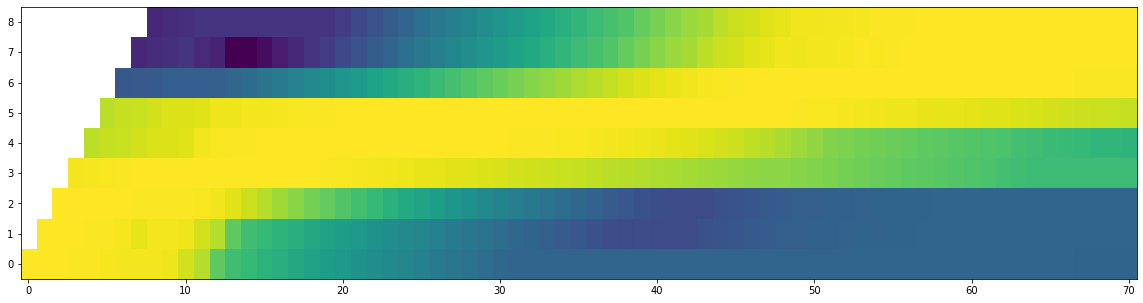

In [30]:
obs_likelihood = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])
logalpha = forward(obs_likelihood, log_startprob, log_transmat)
logbeta = backward(obs_likelihood, log_startprob, log_transmat)

loggamma = statePosteriors(logalpha, logbeta)

print(compare(loggamma, example['loggamma']))

plt.figure(figsize=(20,5))
plt.imshow(np.ma.masked_invalid(loggamma).T, aspect='auto', interpolation='nearest', origin='lower')
plt.show()